Ce programme prend en entrée une photo en jpg avec des bateaux dessus et renvoie la même image avec la déilimitation des bateaux entourés ainsi que leur direction.

Importation des modules

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2


Définition de la fonction distance_to_ellipse (prend en entrée un point et une ellipse et renvoie la distance entre ce point et l'ellipse)

In [10]:
def distance_to_ellipse(point, ellipse):
    center, axes, angle = ellipse
    cos_angle = np.cos(np.deg2rad(angle))
    sin_angle = np.sin(np.deg2rad(angle))
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    x = (dx * cos_angle + dy * sin_angle) / (axes[0] / 2)
    y = (-dx * sin_angle + dy * cos_angle) / (axes[1] / 2)
    distance = np.sqrt(x**2 + y**2)
    return distance

on importe l'image et on trouve ses dimensions

In [11]:
img = imageio.imread('../data/images/airbus_kaggle/bateau.jpg')
hauteur=img.shape[0]
largeur=img.shape[1]

/tmp/ipykernel_84616/2990341560.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/images/airbus_kaggle/bateau.jpg')


On fait apparaître les contours sur l'image

In [12]:
blur = cv2.GaussianBlur(img, (5, 5), 0)
edges = cv2.Canny(blur, 100, 200)

On met les contours dans l'image dans le tuple "contours" (chaque élement du tuple est une liste contenant les points d'un contour)

In [13]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

on vérifie que les contours détectées sont bien des bateaux :

In [14]:
for i in range(len(contours)):
    contour=contours[i]
    
    # On vérifie que la taille du contour est assez grande pour la fonction fitEllipse
    if len(contour)>=5:

        # on vérifie si il n'y a pas de contours imbriqués dans la liste
        if hierarchy[0][i][3] == -1:
                
                #On trouve l'ellipse qui s'approche le plus de la forme
                ellipse = cv2.fitEllipse(contour)
                center, axes, angle = ellipse
                
                #on vérifie que l'ellipse ne soit pas plate (pour ne pas faire de division par 0 plus tard)
                if axes[0]!=0:

                    # on calcule la distance moyenne entre les points du contour et l'ellipse ajustée
                    distances = []
                    for point in contour:
                        distance = distance_to_ellipse(point[0], ellipse)
                        distances.append(distance)
                        mean_distance = np.mean(distances)

                    # on compare la distance moyenne avec un seuil pour décider si le contour s'approche d'un bateau, on regarde aussi le rapport longueur/largeur
                    if (mean_distance/axes[1] <0.1) and (5<axes[1]/axes[0]<12):  
                            
                            #On trace la direction et l'ellipse entourant le bateau        
                            img = cv2.ellipse(img,ellipse,(0,255,0),2)
                            [vx,vy,x,y] = cv2.fitLine(contour, cv2.DIST_L2,0,0.01,0.01)
                            lefty = int((-x*vy/vx) + y)
                            righty = int(((largeur-x)*vy/vx)+y)
                            img = cv2.line(img,(largeur-1,righty),(0,lefty),255,1)

/tmp/ipykernel_84616/2968326695.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x*vy/vx) + y)
/tmp/ipykernel_84616/2968326695.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((largeur-x)*vy/vx)+y)


on affiche l'image

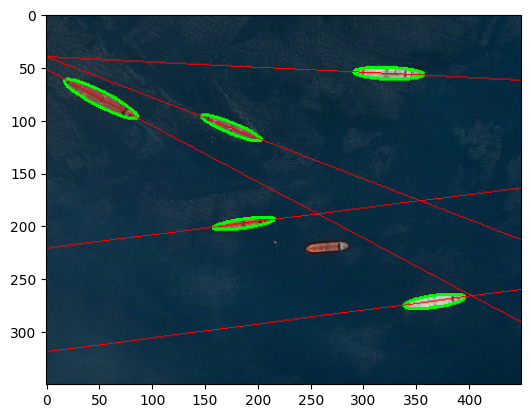

In [15]:
plt.imshow(img)
plt.show()